In [1]:
import os
ON_KAGGLE_KERNEL = os.path.isdir("/kaggle/input")
start_dir = os.getcwd()

if ON_KAGGLE_KERNEL:
    os.chdir("/kaggle/input/utilities/")
else:
    os.chdir(f"{os.environ.get('PYTHONPATH')}/src/utils")

from common import load_structure, save_structure, load_train_file, INPUT_DATA_DIR, OUTPUT_DATA_DIR, SUB_DIR, set_seed, BASE_DIR
from data_proc import create_idvs_with_one_img_in_train_split, create_train_val_loaders, split_into_train_val, load_split
from data_structures import WhaleDataset, TorchConfig
os.chdir(start_dir)

print(INPUT_DATA_DIR)

if not ON_KAGGLE_KERNEL:
    %reload_ext autoreload
    %autoreload 2
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'

import importlib
import pandas as pd
import torch
import numpy as np

def _import_or_install(name: str):
    try:
        globals()[name] = importlib.import_module(name)
        # importlib.import_module(name)
        print(f"{name} found and imported (version {globals()[name].__version__}).")
    except ModuleNotFoundError:
        !pip install -q --upgrade $name
        # importlib.import_module(name)
        globals()[name] = importlib.import_module(name)
        print(f"{name} Installed and imported (version {globals()[name].__version__}).")


/home/paul/projects/Happywhale_competition/data


In [2]:
import os
from pathlib import Path
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np
from PIL import Image
import glob

from U2Net.data_loader import RescaleT
from U2Net.data_loader import ToTensor
from U2Net.data_loader import ToTensorLab
from U2Net.data_loader import SalObjDataset

from U2Net.model import U2NET

from tqdm import tqdm

from IPython import display
import copy
from typing import List
%load_ext line_profiler
torch.cuda.is_available()

True

In [3]:
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d - mi) / (ma - mi)

    return dn

In [4]:
TRAIN_INPUT_DIR = INPUT_DATA_DIR / "train_images"
TEST_INPUT_DIR = INPUT_DATA_DIR / "test_images"
TRAIN_OUTPUT_DIR = OUTPUT_DATA_DIR / "cropped" / "train_images"
TEST_OUTPUT_DIR = OUTPUT_DATA_DIR / "cropped" / "test_images"
MODEL_PATH = BASE_DIR / "U2Net" / "saved_models" / "u2net" / "u2net.pth"
TRAIN_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TEST_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# img_name_list = [glob.glob(str(INPUT_DIR) + os.sep + "*")[0]]

In [6]:
image_list = [str(TEST_INPUT_DIR / f) for f in os.listdir(TEST_INPUT_DIR)]

In [7]:
image_list[:5]

['/home/paul/projects/Happywhale_competition/data/test_images/7d2c0fbe76a740.jpg',
 '/home/paul/projects/Happywhale_competition/data/test_images/427d483ddfb929.jpg',
 '/home/paul/projects/Happywhale_competition/data/test_images/0d50bbb8d482c7.jpg',
 '/home/paul/projects/Happywhale_competition/data/test_images/644962335ed9fd.jpg',
 '/home/paul/projects/Happywhale_competition/data/test_images/0aa702a105517a.jpg']

In [8]:
test_image = Image.open(image_list[0])

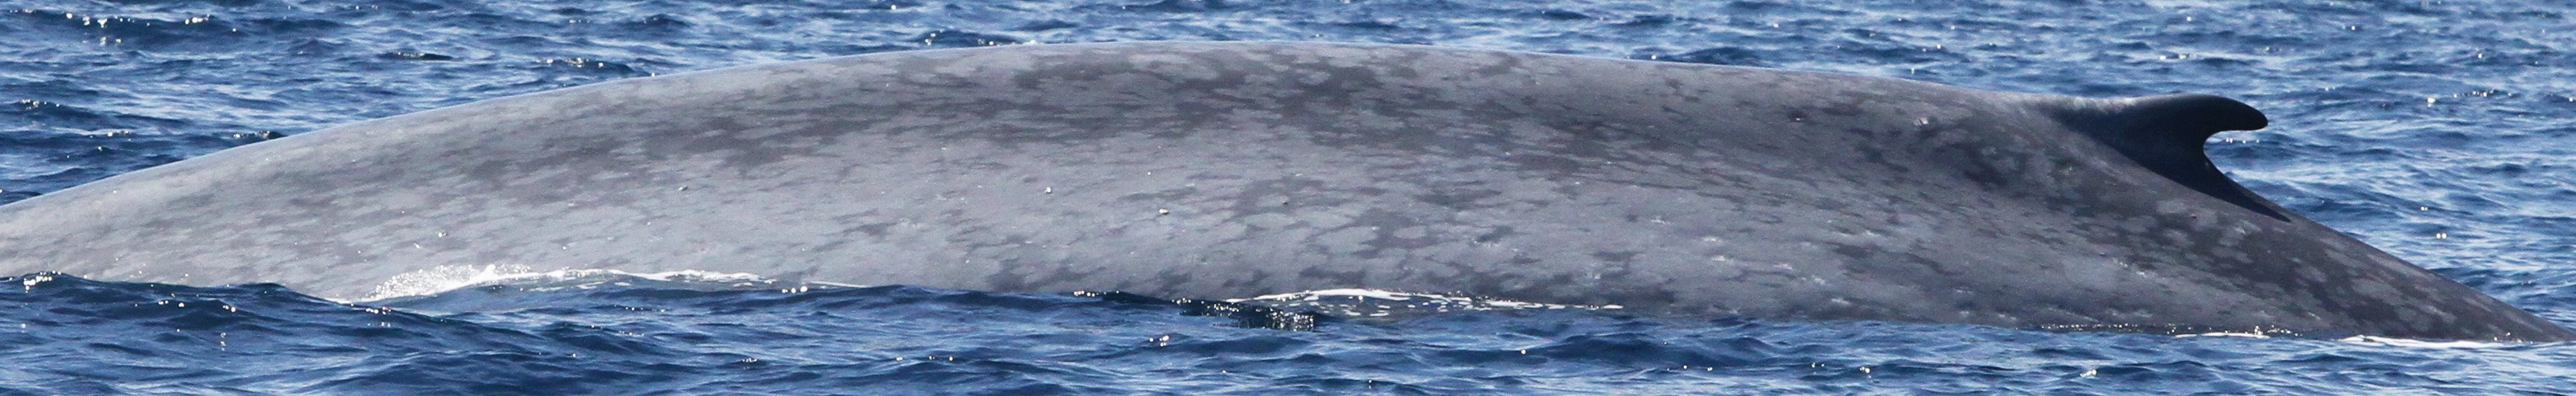

In [9]:
test_image

In [10]:
def crop_images(image_list: List, output_dir: Path, pixel_margin: int = 100, overwrite_present: bool = False):
    local_list = copy.deepcopy(image_list)
    file_names = [f.split("/")[-1] for f in local_list]
    if not overwrite_present:
        local_list = [
            f for i, f in enumerate(local_list) if not (output_dir / file_names[i]).is_file()
        ]
        file_names = [f.split("/")[-1] for f in local_list]

    if not local_list:
        print("No images to process.")
        return

    test_salobj_dataset = SalObjDataset(
        img_name_list=local_list,
        lbl_name_list=[],
        transform=transforms.Compose([RescaleT(320), ToTensorLab(flag=0)]),
    )
    test_salobj_dataloader = DataLoader(
        test_salobj_dataset, batch_size=1, shuffle=False, num_workers=6
    )
    net = U2NET(3, 1)
    if torch.cuda.is_available():
        net.load_state_dict(torch.load(MODEL_PATH))
        net.cuda()
    else:
        net.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
    net.eval()
    bar = tqdm(
        enumerate(test_salobj_dataloader),
        desc="Running Salient Model & Cropping images...",
        total=len(test_salobj_dataloader),
        disable=False
    )

    with torch.no_grad():
        for i, data_test in bar:
            inputs_test = data_test["image"]
            inputs_test = inputs_test.type(torch.FloatTensor)

            if torch.cuda.is_available():
                inputs_test = Variable(inputs_test.cuda())
            else:
                inputs_test = Variable(inputs_test)

            d1, _, _, _, _, _, _ = net(inputs_test)

            pred = d1[:, 0, :, :]
            pred = normPRED(pred).cpu().numpy()

            orig_im = Image.open(local_list[i])
            pred_res = np.array(
                Image.fromarray(pred[0]).resize(
                    (orig_im.width, orig_im.height), resample=Image.BILINEAR
                )
            )
            orig_width, orig_height = orig_im.width, orig_im.height

            dim_1, dim_2 = ((pred_res) > 0.1).nonzero()
            y_min = max(dim_1.min() - pixel_margin, 0)
            y_max = min(dim_1.max() + pixel_margin, orig_height)
            x_min = max(dim_2.min() - pixel_margin, 0)
            x_max = min(dim_2.max() + pixel_margin, orig_width)

            orig_im.crop((x_min, y_min, x_max, y_max)).save(output_dir / file_names[i])


In [11]:
image_list = [str(TEST_INPUT_DIR / f) for f in os.listdir(TEST_INPUT_DIR)]
crop_images(image_list, TEST_OUTPUT_DIR)


Running Salient Model & Cropping images...: 100%|██████████| 4322/4322 [25:21<00:00,  2.84it/s]
